In [1]:
#!pip install fastai
#!pip install fastai.conv_learner
#!pip install scikit-image

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage

In [9]:
path = "/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/"

In [10]:
train = pd.read_csv(os.path.join(path + 'train_ship_segmentations_v2.csv'))

In [11]:
print(train.shape[0],'masks found')

231723 masks found


In [12]:
train.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [25]:
#sample

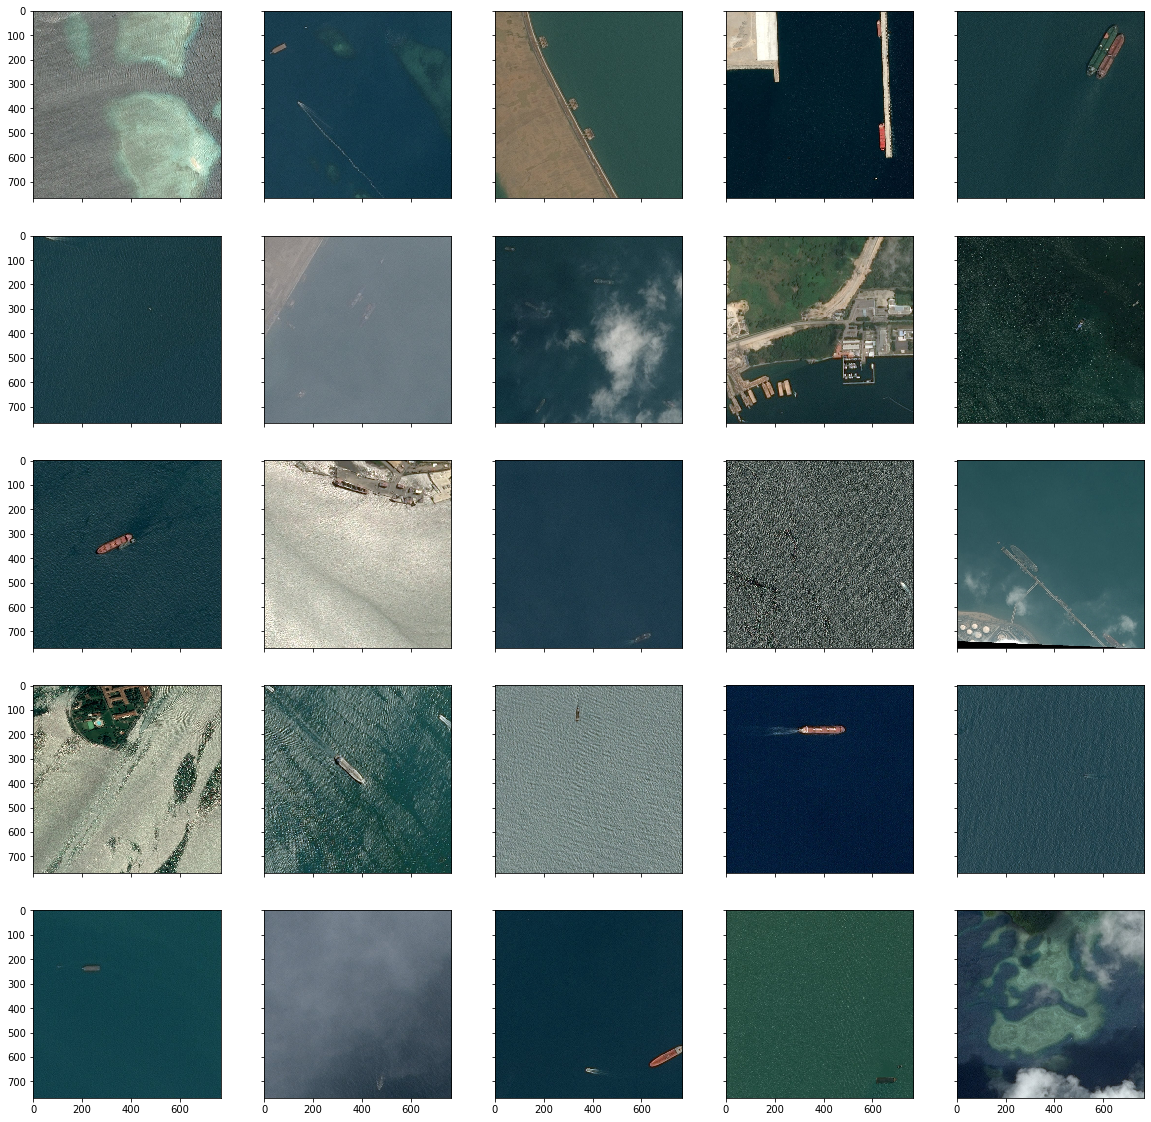

In [14]:
from pathlib import Path

sample = train[~train.EncodedPixels.isna()].sample(25)
fig, ax = plt.subplots(5,5,sharex = 'col', sharey='row')
fig.set_size_inches(20,20)

for i , imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    paths = Path(path + 'train_v2') / '{}'.format(imgid)
    img = imread(paths)
    
    ax[row, col].imshow(img)

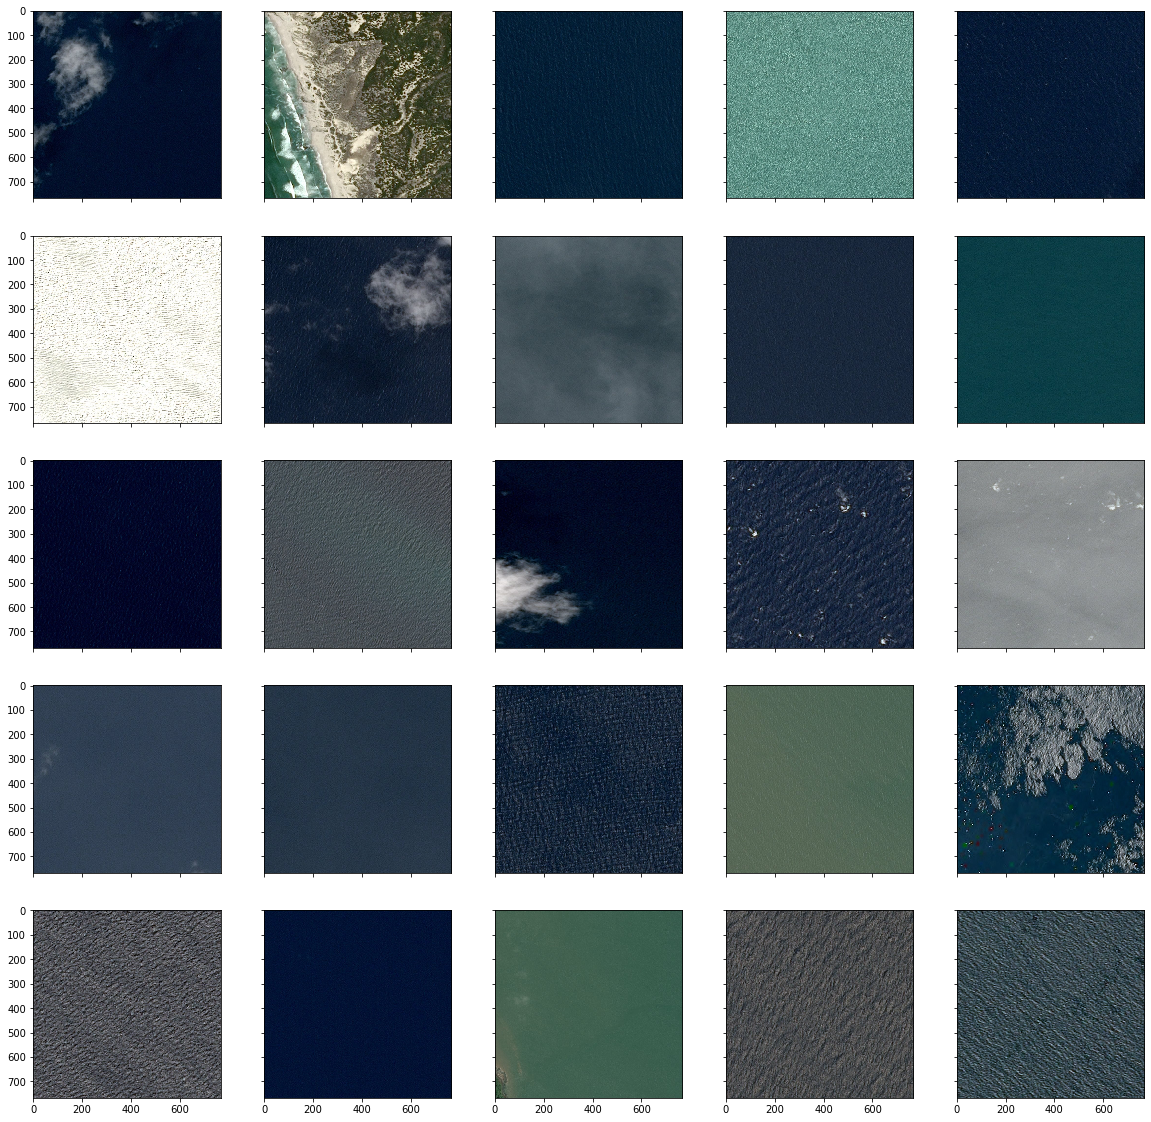

In [15]:
sample = train[train.EncodedPixels.isna()].sample(25)
fig, ax = plt.subplots(5,5,sharex = 'col', sharey='row')
fig.set_size_inches(20,20)

for i , imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    paths = Path(path + 'train_v2') / '{}'.format(imgid)
    img = imread(paths)
    
    ax[row, col].imshow(img)

# Look at class balance

Text(0, 0.5, 'number of Images')

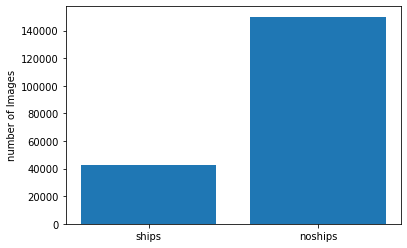

In [16]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()

plt.bar(['ships','noships'], [len(ships),len(noships)])
plt.ylabel('number of Images')

# color distributions between images with ships and those without

In [17]:
mask = train.EncodedPixels.isna()

In [18]:
def get_img(imgid):
    '''Return image array, given ID.'''
    paths = Path(path + 'train_v2') / '{}'.format(imgid)
    return imread(paths)

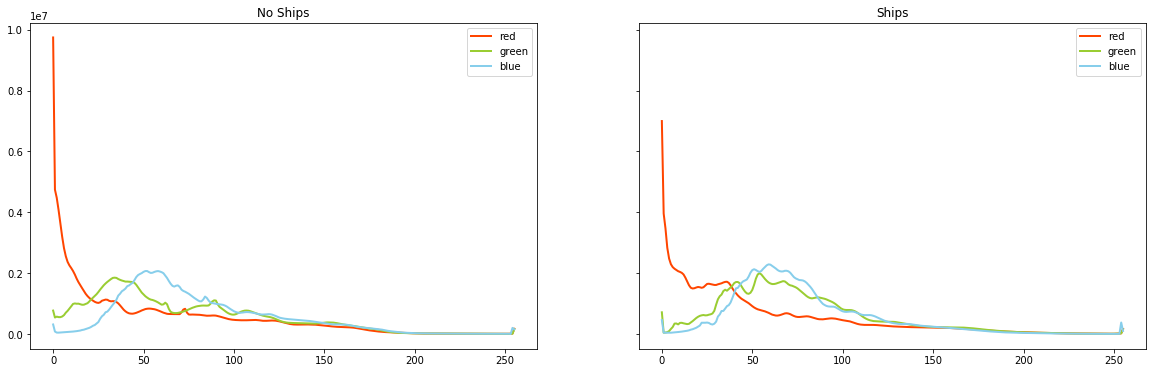

In [19]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(20, 6)

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train[msk].ImageId.sample(250)
    imgs = np.array([get_img(_id) for _id in _ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    ax[i].plot(np.bincount(red.ravel()), color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel()), color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel()), color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)

In [20]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

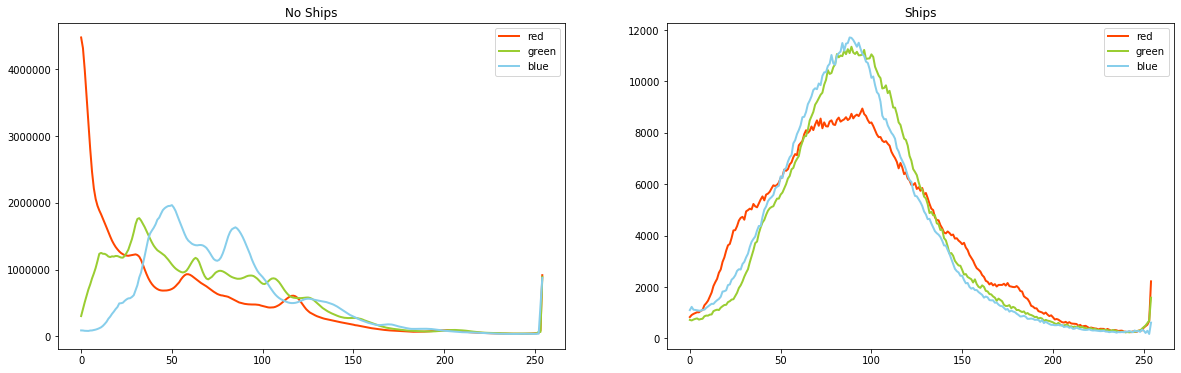

In [21]:
def apply_masks_to_img(img, _id, df):
    '''Apply masks to image given img, its id and the dataframe.'''
    masks = df[df.ImageId == _id].EncodedPixels.apply(lambda x: rle_decode(x)).tolist()
    masks = sum(masks)
    return img * masks.reshape(img.shape[0], img.shape[1], 1)


fig, ax = plt.subplots(1, 2, sharex='col')#, sharey='row')
fig.set_size_inches(20, 6)

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train[msk].ImageId.sample(250)
    imgs = [get_img(_id) for _id in _ids]
    
    # if we have an encoding to decode
    if i == 1:
        imgs = [apply_masks_to_img(i, _id, train) for (i, _id) in zip(imgs, _ids)]

    imgs = np.array(imgs)
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    # skip bincount index 0 to avoid the masked pixels to overpower the others.
    ax[i].plot(np.bincount(red.ravel())[1:], color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel())[1:], color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel())[1:], color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)

# Understanding and plotting rle bounding boxes 
https://www.kaggle.com/julian3833/2-understanding-and-plotting-rle-bounding-boxes

In [22]:
df = pd.read_csv(path + "train_ship_segmentations_v2.csv", index_col=0).dropna()
display(df.head())
df['EncodedPixels']['000155de5.jpg']

EncodedPixels
ImageId                                                         
000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

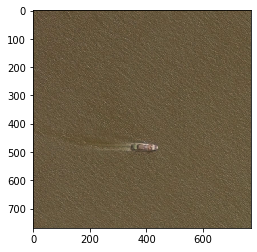

In [23]:
import cv2 as cv
paths = path + 'train_v2/' + '000155de5.jpg'
img = cv.imread(paths)
plt.imshow(img)

In [24]:
rle

NameError: name 'rle' is not defined

In [ ]:
rle = [int(i) for i in df['EncodedPixels']['000155de5.jpg'].split()]
pairs = list(zip(rle[0:-1:2],rle[1::2]))
pairs[:3]

In [ ]:
start = pairs[0][0]
print(f"Original start position: {start}")

coordinate = (start % 768, start // 768)
print(f"Maps to this coordinate: {coordinate}")

back = 768 * coordinate[1] + coordinate[0]
print(f"And back: {back}")

In [ ]:
pixels = [(pixel_position % 768, pixel_position // 768) 
                            for start, length in pairs 
                            for pixel_position in range(start, start + length)]
pixels[:3]

In [ ]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

# First three pixels of this particular bounding box:
rle_to_pixels(df['EncodedPixels']['000155de5.jpg'])[0:3]

# Plotting the bounding boxes as a mask

In [ ]:
#*pizels

In [ ]:
canvas = np.zeros((768,768))
canvas[tuple(zip(*pixels))] =1
plt.imshow(canvas)

In [ ]:
canvas = np.zeros((768,768))
pixels = rle_to_pixels(np.random.choice(df['EncodedPixels']))
canvas[tuple(zip(*pixels))] = 1
plt.imshow(canvas)

# Masking the image with bounding box

In [ ]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()

In [ ]:
df.loc[0, 'ImageId']

In [ ]:
path

In [ ]:
load_img = lambda filename: np.array(PIL.Image.open(f'/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/train_v2/{filename}'))
def apply_mask(image,mask):
    for x,y in mask:
        image[x,y,[0,1]] = 255
    return image

img = load_img(df.loc[0, 'ImageId'])
mask_pixels = rle_to_pixels(df.loc[0, 'EncodedPixels'])
img = apply_mask(img,mask_pixels)
plt.imshow(img)

In [ ]:
w = 6
h = 6

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        row_index = np.random.randint(len(df)) # take a random row from the df
        ax.imshow(apply_mask(load_img(df.loc[row_index, 'ImageId']), rle_to_pixels(df.loc[row_index, 'EncodedPixels'])))
        ax.set_title(df.loc[row_index, 'ImageId'])

References  
Airbus ship data vizualization - a nice data visualization and exploratory data analysis kernel. We didn't copy code from there, but it helped us to quick start the project.
What's next?  
https://www.kaggle.com/meaninglesslives/airbus-ship-detection-data-visualization  

You can check the next kernel of the series, where we explore the data and present the class imbalance problem of the dataset.  

https://www.kaggle.com/julian3833/3-basic-exploratory-analysis